In [1]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, Aer

# Data

* documents: `passport`,  `entry_pass`, `citizen_id`,  `work_pass`, `foreigner_id` and `person_characteristcs`
* imigrant data: `foreigner`, `worker` and `wanted`
* imigrant actions: `bribe`, `emotional_trick`, and `ezic_member`
* actions: `detain`, `check`, `use_weapon`, `confiscate_document` and `fingerprint`
* outputs: `let_pass` and `justify`
* events: `terrorist_attack`
* divergent information: `false_data`, `different_weight` and `different_characteristics`
* inputs : `join_ezic`

In [11]:
# documents
passport = QuantumRegister(1, name="passport")
entry_pass = QuantumRegister(1, name="entry_pass")
citizen_id = QuantumRegister(1, name="citizen_id")
work_pass = QuantumRegister(1, name="work_pass")
foreigner_id = QuantumRegister(1, name="foreigner_id")
person_characteristcs = QuantumRegister(1, name="person_characteristcs")
documents = [passport, entry_pass, citizen_id, work_pass, foreigner_id, person_characteristcs]

In [12]:
#imigrant data
foreigner = QuantumRegister(1, name="foreigner")
worker = QuantumRegister(1, name="worker")
wanted = QuantumRegister(1, name="wanted")
imigrant_data = [foreigner, worker, wanted]

In [16]:
#imigrant actions
bribe = QuantumRegister(1, name="bribe")
emotional_trick = QuantumRegister(1, name="emotional_trick")
ezic_member = QuantumRegister(1, name="ezic_member")
imigrant_actions = [bribe, emotional_trick, ezic_member]

In [20]:
#actions
detain = QuantumRegister(1, name="detain")
check = QuantumRegister(1, name="check")
use_weapon = QuantumRegister(1, name="use_weapon")
confiscate_document = QuantumRegister(1, name="confiscate_document")
fingerprint = QuantumRegister(1, name="fingerprint")
actions = [detain, check, use_weapon, confiscate_document, fingerprint]

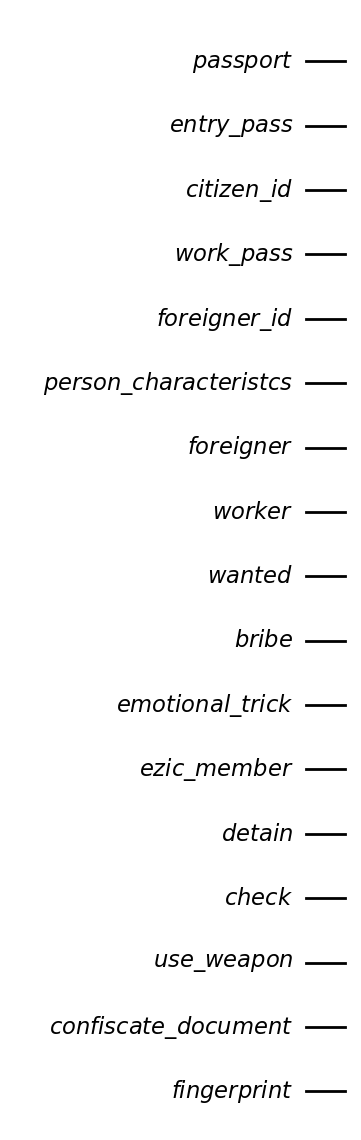

In [21]:
qc = QuantumCircuit(*documents, *imigrant_data, *imigrant_actions, *actions)
qc.draw('mpl')